# SkimLit
The purpose of this proyect is to make a natural language processing (NLP) model to make reading medical abstracts easier (skimmable).

More specificially, we're going to be replicating the deep learning model behind the 2017 paper: "PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts" by Cornell University. You can find it here: https://arxiv.org/abs/1710.06071

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

## Import helper functions
In the past I've added some handy functions to help me in future projects to a Github repo we'll be using.


In [1]:
!wget https://raw.githubusercontent.com/TheMexicanTarzan/Helper-functions/main/Python/TF_Helpers.py

--2024-08-24 17:44:13--  https://raw.githubusercontent.com/TheMexicanTarzan/Helper-functions/main/Python/TF_Helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10247 (10K) [text/plain]
Saving to: ‘TF_Helpers.py’

TF_Helpers.py       100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-08-24 17:44:13 (14.6 MB/s) - ‘TF_Helpers.py’ saved [10247/10247]



In [2]:
from TF_Helpers import calculate_results

## Get data

Since we'll be replicating the paper above, let's download the data they used.
We can do so from the author's Github: https://github.com/Franck-Dernoncourt/pubmed-rct.git

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
# Check what files are in the PubMed 200k dataset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [5]:
# Start our experiments using the 20k dataset with numbers replaced by the @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data
Now we've got some text data, it's time to **become one with the data**. For this, we'll first need to visualize

In [7]:
# Create function to  read the lines of a document
def get_lines(filename):
  """
  Reads a filename and returns the lines of text as a list
  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

### I think the data would be best represented this way:

```
[{ line_number: 0,
  'target': 'BACKGROUND'
  'text': "Emotional eating is associated with overeating and the development of obesity\n"
  'total_lines': 11},
  ...]
```

### Lets write a function to turn each of our datasets into the above format

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples)), len(val_samples), len(test_samples)

180040
CPU times: user 740 ms, sys: 158 ms, total: 899 ms
Wall time: 1.06 s


(None, 30212, 30135)

In [11]:
# Check the first abstract of our training data
val_samples[:10]

[{'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 9},
 {'target': 'BACKGROUND',
  'text': 'it is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_lines': 9},
 {'target': 'OBJECTIVE',
  'text': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'line_number': 2,
  'total_lines': 9},
 {'target': 'METHODS',
  'text': 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'line_number': 3,
  'total_lines': 9},
 {'targe

Now that our data is in the format of a list of dictionaries, let's turn it into a DataFrame to further visualize

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels. Do we have any imbalances?
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


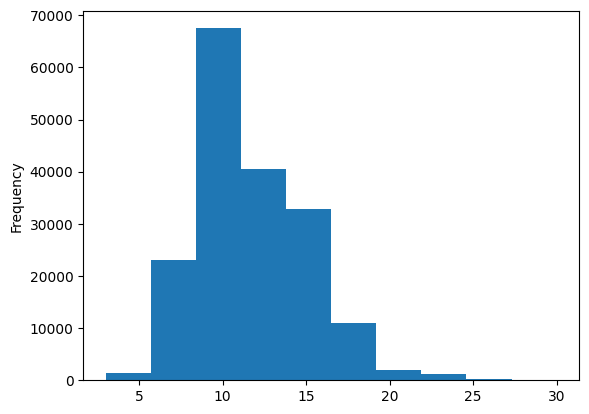

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric data)
We'll create label and one hot encoded labels but we can use either one

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# See what they look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into ints
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what they look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from label encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments..
We'll create a series of models to see which one works best

### Baseline model: Naive Bayes Model with tfidf embedding

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create the tokenization and model pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate our baseline
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy of {baseline_score * 100:.2f}%")

Our baseline model achieves an accuracy of 72.18%


In [22]:
# Make predictions using the baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

Before we start creating deep models, we've got to create vectorization and embedding layers

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

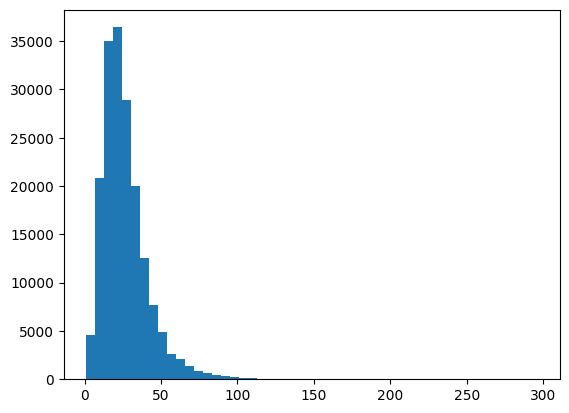

In [26]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 50);

In [27]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [28]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer to turn words into numbers.

In [29]:
# How many words are in our vocabulary? (taken from table 2 in https://arxiv.org/abs/1710.06071)
max_tokens = 68000

In [30]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [31]:
# Adapt vecotrizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"Lenght of text: {len(target_sentence.split())}")
print(f"Vectorized text: {text_vectorizer([target_sentence])}")

Text:
whereas it is generally assumed that cams such as healing have beneficial effects on well-being , our results indicated no overall effectiveness of energy healing on qol , depressive symptoms , mood , and sleep quality in colorectal cancer patients .
Lenght of text: 41
Vectorized text: [[  436   185    20  1153  6124    28 12774   345    25   976    99   748
     71    18  1343   246   117   808    33   188   257     4   756   976
     18   609   649   144  1280     3   354   141     5  1264   135    12
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [33]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom embedding

In [35]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")

In [36]:
# Show example embedding
print(f"Sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding): \n {vectorized_sentence} \n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence} \n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 whereas it is generally assumed that cams such as healing have beneficial effects on well-being , our results indicated no overall effectiveness of energy healing on qol , depressive symptoms , mood , and sleep quality in colorectal cancer patients .

Sentence after vectorization (before embedding): 
 [[  436   185    20  1153  6124    28 12774   345    25   976    99   748
     71    18  1343   246   117   808    33   188   257     4   756   976
     18   609   649   144  1280     3   354   141     5  1264   135    12
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]] 

Sentence after embedding: 
 [[[-0.04065298 -0.01709773 -0.02630453 ...  0.04791253  0.02058979
    0.02900654]
  [ 0.01142097 -0.00881834 -0.03043572 ... -0.03486001 -0.02746896
   -0.00269321]
  [-0.02580816  0.01597445 -0.00724287 ...  0.01591836  0.02045064
   -0.02235021]
  ...
  [ 0.0115976   0.01688272 -0.0113951

### Creating datasets to load data as fast as possible


In [37]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [39]:
# Create a 1D conv model to process sequences
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "model_1")

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [40]:
model_1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Fit the model
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch = int(0.1 * len(train_dataset)), # To make experiments faster and figure out what works best, use only 10% of data to make faster experiments
                        epochs = 3,
                        validation_data = valid_dataset,
                        validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.5223 - loss: 1.1692 - val_accuracy: 0.7400 - val_loss: 0.6909
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - accuracy: 0.7445 - loss: 0.6833 - val_accuracy: 0.7726 - val_loss: 0.6269
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.7713 - loss: 0.6227 - val_accuracy: 0.7876 - val_loss: 0.5914


In [42]:
# Evaluate on the whole validation dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7854 - loss: 0.5960


[0.5983147025108337, 0.7859128713607788]

In [43]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


array([[4.2945099e-01, 1.4469510e-01, 1.1355147e-01, 2.7594569e-01,
        3.6356725e-02],
       [4.3174154e-01, 2.8631276e-01, 9.9304402e-03, 2.6439208e-01,
        7.6231295e-03],
       [1.6517711e-01, 6.6190623e-03, 2.2566589e-03, 8.2590628e-01,
        4.0849740e-05],
       ...,
       [5.6381459e-06, 6.6367741e-04, 8.2488183e-04, 2.6713913e-06,
        9.9850321e-01],
       [4.7333252e-02, 4.4190335e-01, 9.8289214e-02, 5.6000125e-02,
        3.5647410e-01],
       [1.8144499e-01, 6.4621377e-01, 5.1114988e-02, 4.5934156e-02,
        7.5292110e-02]], dtype=float32)

In [44]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [45]:
# Calculate model 1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.59128822984245,
 'precision': 0.7821290177125109,
 'recall': 0.7859128822984245,
 'f1': 0.7832450548513221}

## Model 2: Feature extraction with pretrained token embeddings

Now, let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder.

The paper originally used GloVe embeddings, however, we're going to sick with the latest created USE pretrained model.

In [46]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "Universal_sentence_encoder")

In [47]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence}")
print(f"length of sentence embedding: \n {len(use_embedded_sentence[0])}")

Random sentence: 
 this rct will test whether the llttf intervention is effective and/or cost-effective .
Sentence after embedding:
 [[ 4.07881662e-02 -3.65260281e-02 -1.22398119e-02 -2.07305141e-02
  -5.68757728e-02 -5.92195662e-04  5.65586165e-02 -4.77181673e-02
   3.37692769e-03  3.89520600e-02  8.19853768e-02  3.48036028e-02
   9.07182992e-02  3.75963300e-02  2.57434268e-02  1.12621197e-02
  -3.03972159e-02  5.05461656e-02 -1.43767130e-02  1.73125900e-02
   6.96629882e-02  4.43313271e-02 -3.37180682e-02 -4.95346040e-02
  -4.45129573e-02 -1.20921060e-04 -3.16503383e-02 -3.53757069e-02
  -3.26129198e-02  3.85037214e-02  4.96047586e-02  6.86155334e-02
   1.39716445e-02  3.62280011e-02 -2.28462704e-02  2.04258449e-02
  -2.75775138e-02 -6.64134556e-03  3.95383276e-02 -3.34399305e-02
  -6.08009547e-02 -1.65355187e-02 -7.45086791e-03  4.82892357e-02
  -6.78167343e-02 -4.95174294e-03  4.33481112e-02 -4.42674868e-02
   7.27406144e-02 -4.41957600e-02  3.17970105e-02  4.76261489e-02
   5.2481

### Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [48]:
# Wrap the pretrained embedding layer
embedding = layers.Lambda(
    lambda x: tf_hub_embedding_layer(x),
    output_shape = (512,),
    name = "USE"
)

# Build the model
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = embedding(inputs)
x = layers.Dense(128, activation = "relu")(pretrained_embedding)
outputs = layers.Dense(5, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs = inputs, outputs = outputs, name = "model_2")

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [49]:
model_2.summary()

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ USE (Lambda)                         │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Fit model
history_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * (len(valid_dataset))))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5676 - loss: 1.0920 - val_accuracy: 0.6868 - val_loss: 0.7945
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7012 - loss: 0.7695 - val_accuracy: 0.7118 - val_loss: 0.7546
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7142 - loss: 0.7519 - val_accuracy: 0.7191 - val_loss: 0.7245


In [51]:
# Evaluate on the whole dataset
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7152 - loss: 0.7365


[0.7381903529167175, 0.7148153185844421]

In [52]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


array([[4.3032929e-01, 3.6601874e-01, 1.8425186e-03, 1.9406617e-01,
        7.7433460e-03],
       [2.9511693e-01, 5.6001896e-01, 3.9329459e-03, 1.3819826e-01,
        2.7329151e-03],
       [2.2286558e-01, 1.1672643e-01, 1.3362919e-02, 6.1055201e-01,
        3.6493074e-02],
       ...,
       [1.4710276e-03, 6.5895864e-03, 4.6596412e-02, 7.4524095e-04,
        9.4459772e-01],
       [3.9684912e-03, 5.2048814e-02, 2.2572707e-01, 1.4570882e-03,
        7.1679848e-01],
       [1.3663213e-01, 3.3016706e-01, 4.6972236e-01, 6.6003166e-03,
        5.6878146e-02]], dtype=float32)

In [53]:
# Convert the prediction probabilities to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [54]:
# Calculate results from TF Hub pretrained embedding
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.4815305176751,
 'precision': 0.7155262505605244,
 'recall': 0.714815305176751,
 'f1': 0.7119031424220811}

## Model 3: Conv1D with character embeddings
The paper which we're replicating states they used a combination of token and character-level embeddings
Previously we've used only token-level embeddings. So let's use character embeddings.

### Creating a character level tokenizer

In [55]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h i s   r c t   w i l l   t e s t   w h e t h e r   t h e   l l t t f   i n t e r v e n t i o n   i s   e f f e c t i v e   a n d / o r   c o s t - e f f e c t i v e   .'

In [56]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [57]:
# What is the average char lenght?
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

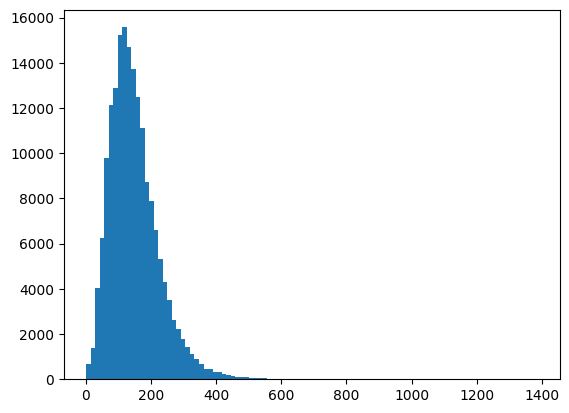

In [58]:
# Checl the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_len, bins = 100);

In [59]:
# Find what character lenght covers 95% of sequences
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [60]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [61]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer")

In [62]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [63]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [64]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n {random_train_chars}")
print(f"\nLenght of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars: \n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars)}")

Charified text: 
 f u r t h e r m o r e   ,   t h i s   m a i n   e f f e c t   w a s   n o t   p a r t i c u l a r l y   p r o n o u n c e d   w h e n   t h e   g a m e   w a s   p l a y e d   o n l i n e   .

Lenght of random_train_chars: 191

Vectorized chars: 
 [[17 16  8  3 13  2  8 15  7  8  2  3 13  4  9 15  5  4  6  2 17 17  2 11
   3 20  5  9  6  7  3 14  5  8  3  4 11 16 12  5  8 12 19 14  8  7  6  7
  16  6 11  2 10 20 13  2  6  3 13  2 18  5 15  2 20  5  9 14 12  5 19  2
  10  7  6 12  4  6  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Creating a character level embedding

In [65]:
# Create car embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name = "char_embed")


In [66]:
# Test our character embedding layer
print(f"Charified text: \n {random_train_chars} \n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding: \n {char_embed_example})")
print(f"Characters embedding shape: {char_embed_example.shape}")

Charified text: 
 f u r t h e r m o r e   ,   t h i s   m a i n   e f f e c t   w a s   n o t   p a r t i c u l a r l y   p r o n o u n c e d   w h e n   t h e   g a m e   w a s   p l a y e d   o n l i n e   . 

Embedded chars. (after vectorization and embedding: 
 [[[-0.01614506  0.01747265 -0.02096816 ... -0.02595047 -0.02048242
    0.02687502]
  [-0.02772452 -0.00795804  0.03224725 ...  0.00529356  0.04490949
   -0.03549522]
  [ 0.00098683  0.01823762  0.0274657  ...  0.03025122 -0.03931112
    0.01786567]
  ...
  [ 0.04126812  0.0308959  -0.03283645 ... -0.04227987 -0.02050933
    0.04655584]
  [ 0.04126812  0.0308959  -0.03283645 ... -0.04227987 -0.02050933
    0.04655584]
  [ 0.04126812  0.0308959  -0.03283645 ... -0.04227987 -0.02050933
    0.04655584]]])
Characters embedding shape: (1, 290, 25)


### Building a Conv1D model with character embeddings

In [67]:
# Make a conv 1D layer
inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_3")

# Compile
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [68]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [69]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.4201 - loss: 1.3960 - val_accuracy: 0.5798 - val_loss: 1.0460
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.5821 - loss: 1.0453 - val_accuracy: 0.6213 - val_loss: 0.9779
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.6227 - loss: 0.9591 - val_accuracy: 0.6533 - val_loss: 0.9025


In [70]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


array([[0.13274187, 0.5495976 , 0.0615052 , 0.23826838, 0.01788688],
       [0.19304036, 0.5755723 , 0.03291546, 0.11794129, 0.08053062],
       [0.10375473, 0.17659146, 0.3671998 , 0.25433508, 0.09811883],
       ...,
       [0.0212226 , 0.03369692, 0.19775008, 0.03201969, 0.71531075],
       [0.04896356, 0.18560566, 0.41273528, 0.05254333, 0.30015215],
       [0.47256133, 0.32898417, 0.08045791, 0.09947256, 0.01852398]],
      dtype=float32)

In [71]:
# Convert the probabilities to labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 2, 0])>

In [72]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)

## Model 4: Combining pretrained token embeddings + character embeddings

1. Create token-level embedding model
2. Create a character-level model
3. Combine 1 & 2 with a concatenate
4. Build a series of output layers on top of 3 similar to Figure 1 in section 4.2 of the paper
5. Construct a model which takes token and character level sequences and outputs sequence label probabilities

In [73]:
# 1. Setup the token inputs/model
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embeddings = embedding(token_inputs)
token_output = layers.Dense(128, activation  ="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)
# 2. Setup char inputs/model
char_inputs = layers.Input(shape  =(1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)
# 3. Concatenate 1 and 2
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model. output,
                                                                    char_model.output])
# 4. Create output layers and add dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. Contruct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_and_char")

In [74]:
model_4.summary()

Model: "model_4_token_and_char"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ USE (Lambda)              │ (None, 512)            │              0 │ token_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         65,664 │ USE[1][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 48)             │          9,600 │ char_embed[1][0],      │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 176)            │              0 │ dense_4[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 176)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         22,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 5)              │            645 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 99,265 (387.75 KB)

 Trainable params: 99,265 (387.75 KB)

 Non-trainable params: 0 (0.00 B)

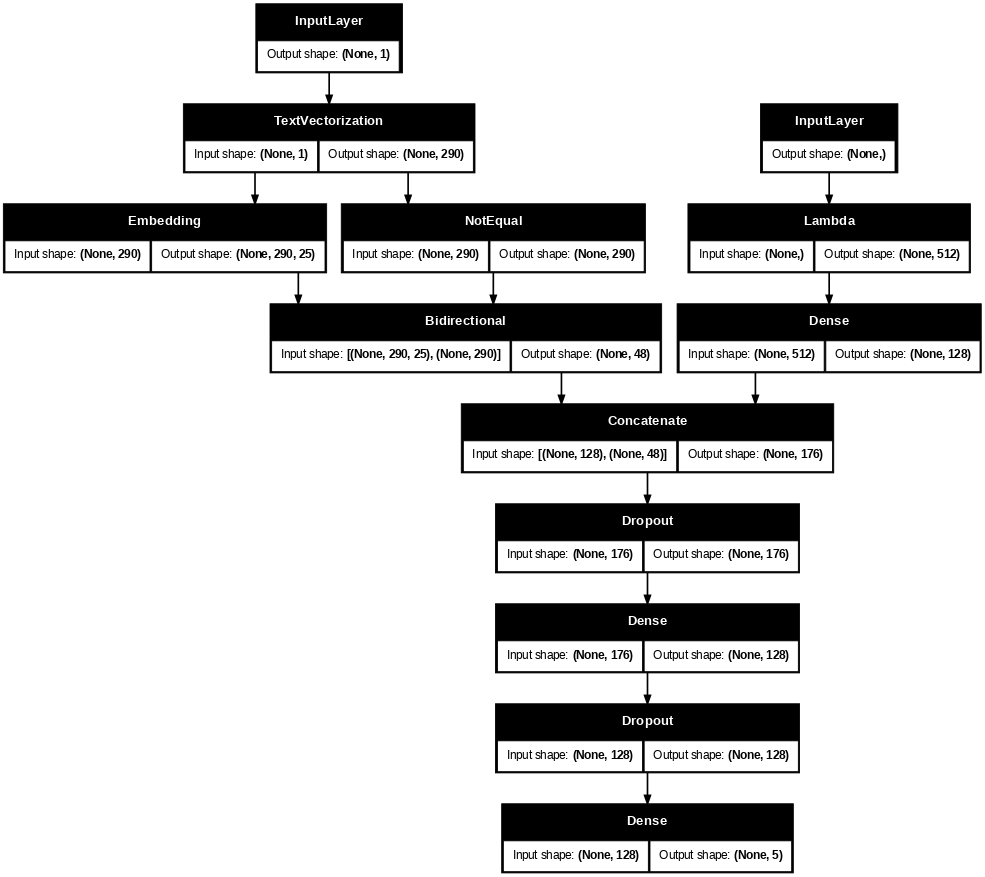

In [75]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True, dpi = 60)

In [76]:
# Compile the model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Combining token and character data into a tf.data dataset


In [77]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [78]:
# Repeat the above steps for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [79]:
# Check out out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [80]:
# Fit the model
history_4 = model_4.fit(train_char_token_dataset,
                        epochs = 3,
                        steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                        validation_data = val_char_token_dataset,
                        validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 192s 328ms/step - accuracy: 0.5234 - loss: 1.1681 - val_accuracy: 0.6918 - val_loss: 0.7926
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 166s 296ms/step - accuracy: 0.6927 - loss: 0.8098 - val_accuracy: 0.7257 - val_loss: 0.7180
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 163s 291ms/step - accuracy: 0.7017 - loss: 0.7774 - val_accuracy: 0.7337 - val_loss: 0.6905


In [81]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - accuracy: 0.7325 - loss: 0.6937


[0.6954107880592346, 0.7347742915153503]

In [82]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 65s 67ms/step


array([[4.5109457e-01, 3.4337920e-01, 4.6104938e-03, 1.9181323e-01,
        9.1024069e-03],
       [3.0723768e-01, 5.1492065e-01, 2.5225808e-03, 1.7292620e-01,
        2.3929116e-03],
       [2.5234169e-01, 1.4531042e-01, 4.0031433e-02, 5.2662748e-01,
        3.5688985e-02],
       ...,
       [6.1913609e-04, 8.3414605e-03, 5.6246758e-02, 3.1855624e-04,
        9.3447411e-01],
       [4.7851466e-03, 7.0468143e-02, 2.2924712e-01, 2.4466407e-03,
        6.9305295e-01],
       [2.2545241e-01, 4.7626841e-01, 2.1863358e-01, 2.8395800e-02,
        5.1249795e-02]], dtype=float32)

In [83]:
# Format pred_probs into labels
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [84]:
# Get results of token char hybrid model
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 73.47742618826956,
 'precision': 0.7354608697038778,
 'recall': 0.7347742618826956,
 'f1': 0.7321356627316784}

 ## Model 5: Transfer learning + character embeddings + positional embeddings

In [85]:
# Lets see our data once again to figure out the positions in data
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


**Note:** Any engineered features need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [86]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

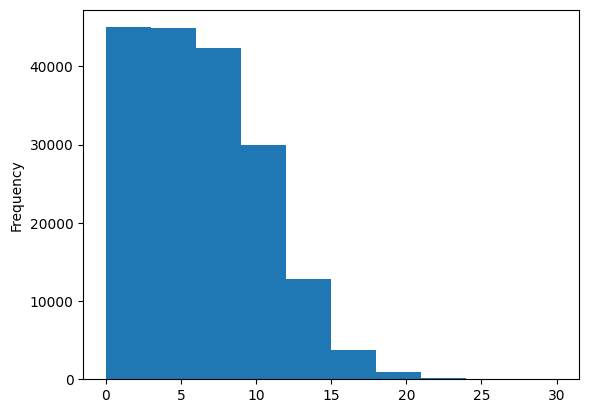

In [87]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [88]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature

In [89]:
# How many different number of lines are there ?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

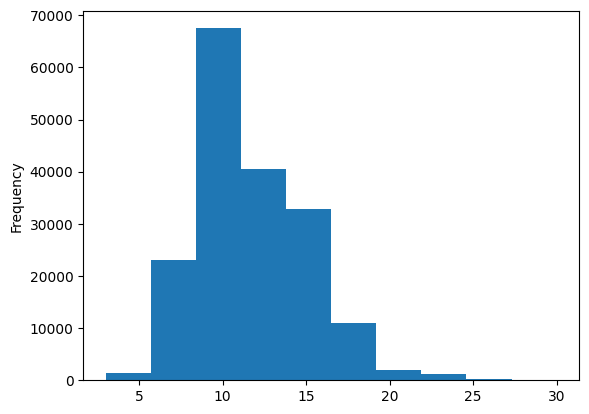

In [90]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [91]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [92]:
# Use Tensorflow to create one-hot encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

### Building the embedding model
1. Create token level model
2. Create character level model
3. Create model for "line number" feature
4. Create model for "total_lines" feature
5. Combine the outputs of 1 and 2
6. Combine the outputs of 3, 4 and 5
7. Create an output layer to accept the embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into a tf.keras model

In [93]:
# 0. Reinstanciate transfer learning layer
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "Universal_sentence_encoder")

embedding = layers.Lambda(
    lambda x: tf_hub_embedding_layer(x),
    output_shape = (512,),
    name = "USE"
)

# 1. Token Inputs
token_inputs = layers.Input(shape = [], dtype = "string",  name = "token_inputs")
token_embeddings = embedding(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)
# 2. Char inputs
char_inputs = layers.Input(shape = (1,), dtype = "string", name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line numbers
line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_inputs")
line_number_outputs = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = line_number_outputs)

# 4. Total lines
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_inputs")
total_lines_outputs = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = total_lines_outputs)

# 5. Combine the outputs of 1 and 2
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
x = layers.Dense(256, activation = "relu")(combined_embeddings)
x = layers.Dropout(0.5)(x)

# 6. Combine the positional embedding with combined_embeddings
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([line_number_model.output,
                                                                                   total_lines_model.output,
                                                                                   x])

# 7. Create output layer
output_layer = layers.Dense(5, activation = "softmax", name = "output_layer")(tribrid_embeddings)

# 8. Put together model with all inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = [output_layer])

In [94]:
model_5.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ USE (Lambda)              │ (None, 512)            │              0 │ token_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[2][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[2][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         65,664 │ USE[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 48)             │          9,600 │ char_embed[2][0],      │
│ (Bidirectional)           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_token_hybrid_embedd… │ (None, 176)            │              0 │ dense_7[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_inputs        │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_inputs        │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │         45,312 │ char_token_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 32)             │            512 │ line_number_inputs[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 32)             │            672 │ total_lines_inputs[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_token_positional_em… │ (None, 320)            │              0 │ dense_8[0][0],         │
│ (Concatenate)             │                        │                │ dense_9[0][0],         │
│                           │                        │                │ dropout_2[0][0]        │
├──────────────────────

 Total params: 124,065 (484.63 KB)

 Trainable params: 124,065 (484.63 KB)

 Non-trainable params: 0 (0.00 B)

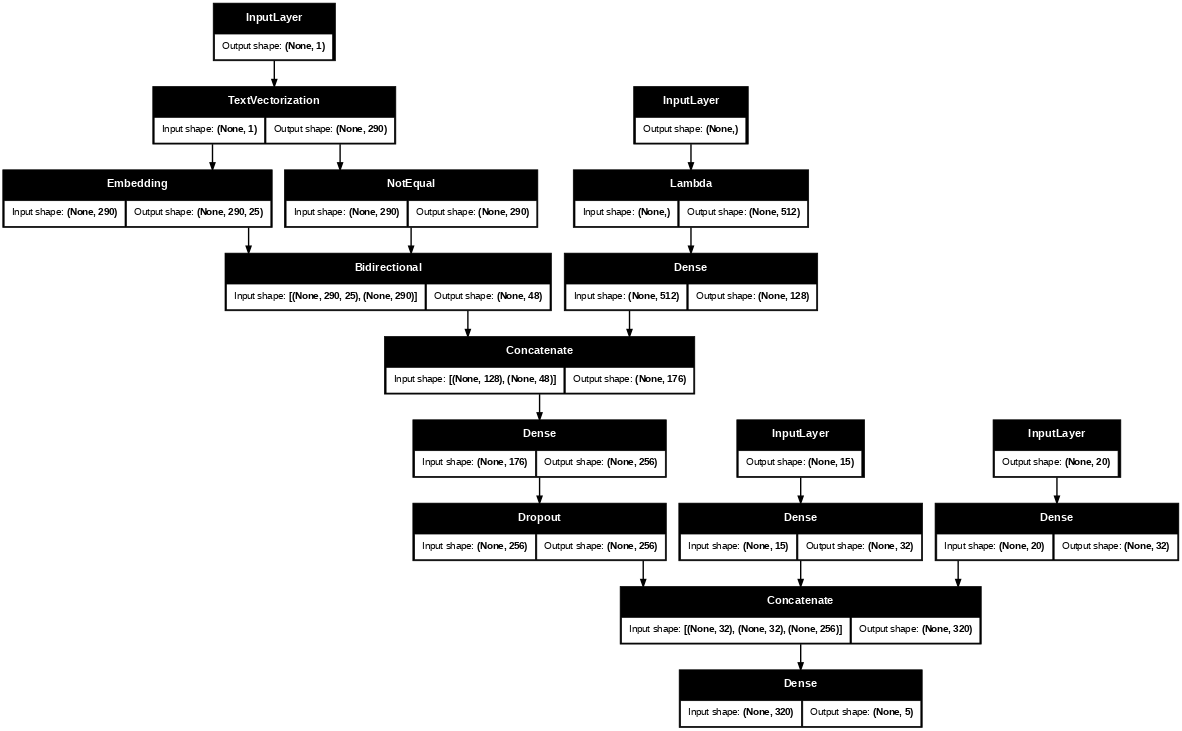

In [95]:
# Plot the model
plot_model(model_5, show_shapes = True, dpi = 50)

**Label smoothing:** reduces prediction confidence to improve generalization

In [96]:
# Compile the model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Creating performant data pipelines with all four kinds of inputs

In [97]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [98]:
# Check input shapes
train_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [99]:
# Fit the model 5
history_5 = model_5.fit(train_char_token_pos_dataset,
                        steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                        epochs = 3,
                        validation_data = val_char_token_pos_dataset,
                        validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 176s 296ms/step - accuracy: 0.6218 - loss: 1.2254 - val_accuracy: 0.8035 - val_loss: 0.9826
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 166s 295ms/step - accuracy: 0.8115 - loss: 0.9708 - val_accuracy: 0.8301 - val_loss: 0.9369
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 168s 298ms/step - accuracy: 0.8199 - loss: 0.9525 - val_accuracy: 0.8351 - val_loss: 0.9342


In [100]:
# Make predictoins
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose = 1)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 62s 65ms/step


array([[0.48436683, 0.12278618, 0.00939289, 0.36740068, 0.01605338],
       [0.5544249 , 0.10878123, 0.04062079, 0.2874663 , 0.00870699],
       [0.281055  , 0.11884817, 0.0950824 , 0.44605672, 0.05895767],
       ...,
       [0.02656071, 0.11718086, 0.04442979, 0.026687  , 0.78514165],
       [0.03074166, 0.3057067 , 0.0837458 , 0.02446608, 0.55533975],
       [0.25934747, 0.47815108, 0.13791767, 0.05005129, 0.07453245]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

In [102]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.49993380113861,
 'precision': 0.8343249645900328,
 'recall': 0.8349993380113861,
 'f1': 0.833949602714751}

## Compare model results

In [103]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.591288,0.782129,0.785913,0.783245
model_2_pretrained_token_embedding,71.481531,0.715526,0.714815,0.711903
model_3_custom_char_embedding,64.335363,0.637771,0.643354,0.630314
model_4_hybrid_char_token_embedding,73.477426,0.735461,0.734774,0.732136
model_5_pos_char_token_embedding,83.499934,0.834325,0.834999,0.833950


In [104]:
# Normalize the accuracy
all_model_results["accuracy"] = all_model_results["accuracy"]/100

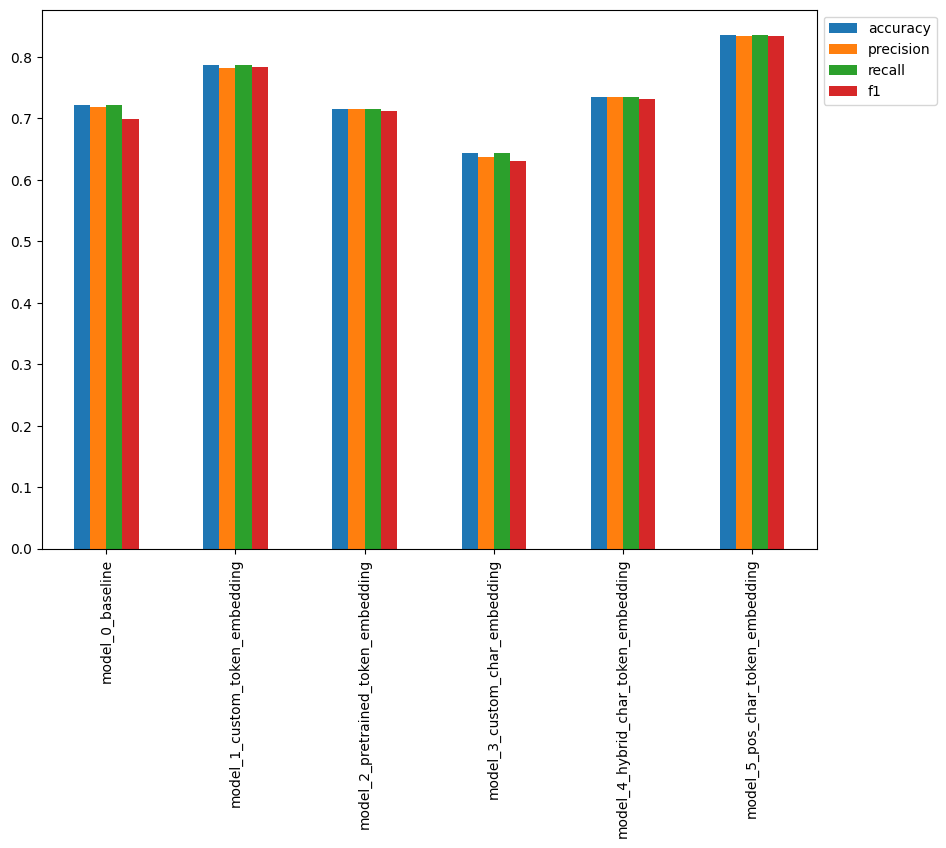

In [105]:
# Plot and compare all model results
all_model_results.plot(kind = "bar", figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

<Axes: >

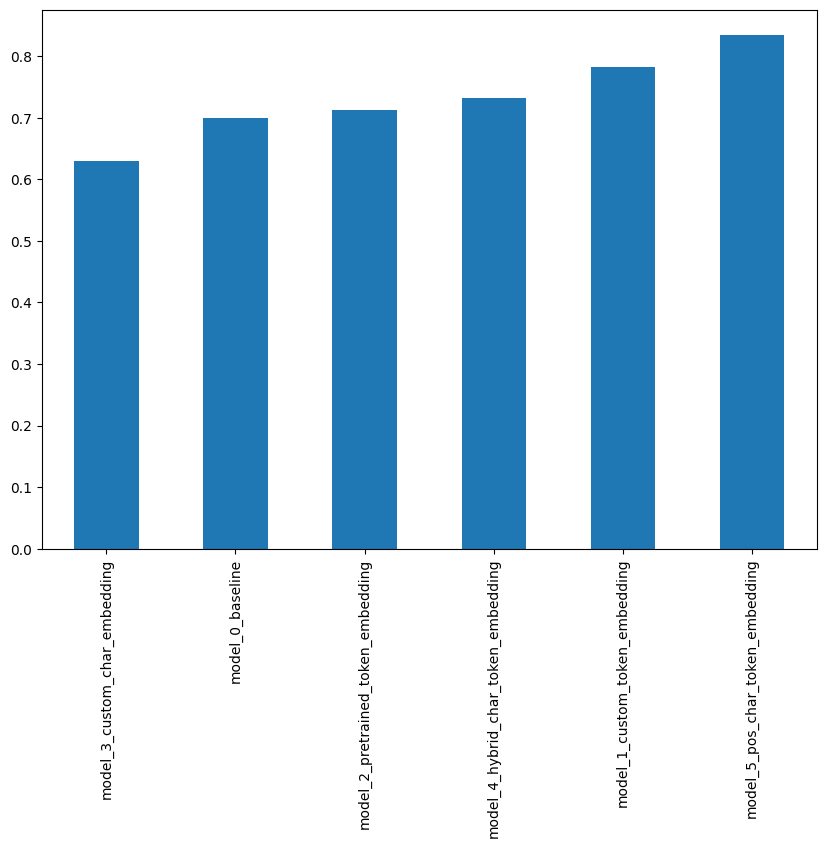

In [106]:
# Sort model results by f1 score
all_model_results.sort_values("f1", ascending = True)["f1"].plot(kind = "bar", figsize = (10,7))

## Finding the most wrong predictions
Another important aspect of testing is finding the wrong predictions your model was the most confident on.


In [107]:
# Get list of class names of test predictions
val_pred_classes = [label_encoder.classes_[pred] for pred in model_5_preds]
val_pred_classes

['BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'BACKGROUND',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'CONCLUSIONS',
 'RESULTS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'RESULTS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESU

In [108]:
# Create prediction-enriched test dataframe
val_df["prediction"] = val_pred_classes # create column with test prediction class names
val_df["pred_prob"] = tf.reduce_max(model_5_pred_probs, axis=1).numpy() # get the maximum prediction probability
val_df["correct"] = val_df["prediction"] == val_df["target"] # create binary column for whether the prediction is right or not
val_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9,BACKGROUND,0.484367,True
1,BACKGROUND,it is not clear whether these patients would b...,1,9,BACKGROUND,0.554425,True
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9,OBJECTIVE,0.446057,True
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9,METHODS,0.679997,True
4,METHODS,primary outcomes were improvement in quality o...,4,9,METHODS,0.658534,True
5,RESULTS,sixty-five patients were randomized .,5,9,RESULTS,0.659934,True
6,RESULTS,fifty-nine patients started treatment ( @ rece...,6,9,RESULTS,0.721972,True
7,RESULTS,fifty-six patients took the full @ months of m...,7,9,RESULTS,0.700310,True
8,RESULTS,"between the voriconazole and placebo groups , ...",8,9,RESULTS,0.828093,True
9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9,9,CONCLUSIONS,0.732018,True


In [109]:
# Sort the wrong predictions by prediction confidence and select the first 100
top_100_wrong = val_df[val_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
28492,CONCLUSIONS,clinicaltrials.gov id : nct@ .,15,15,BACKGROUND,0.949410,False
22444,CONCLUSIONS,clinicaltrials.gov registration number : nct@ .,15,15,BACKGROUND,0.931837,False
9498,METHODS,( clinicaltrials.gov nct@ ) .,7,13,BACKGROUND,0.924687,False
24615,CONCLUSIONS,clinicaltrials.gov identifier : nct @ .,15,15,BACKGROUND,0.922986,False
18115,BACKGROUND,to test the hypothesis that the administration...,0,11,OBJECTIVE,0.922075,False
...,...,...,...,...,...,...,...
7006,RESULTS,polysomnography was conducted over @ nights at...,5,12,METHODS,0.834246,False
30003,METHODS,p > @ indicated no significant difference .,8,12,RESULTS,0.834201,False
765,BACKGROUND,"double-blind , placebo-controlled , functional...",10,10,CONCLUSIONS,0.834101,False
12966,RESULTS,"in this crossover study , healthy subjects ( @...",3,9,METHODS,0.833588,False


Visualize...

In [110]:
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")


Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9494097828865051, Line number: 15, Total lines: 15

Text:
clinicaltrials.gov id : nct@ .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9318373203277588, Line number: 15, Total lines: 15

Text:
clinicaltrials.gov registration number : nct@ .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9246869683265686, Line number: 7, Total lines: 13

Text:
( clinicaltrials.gov nct@ ) .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9229859709739685, Line number: 15, Total lines: 15

Text:
clinicaltrials.gov identifier : nct @ .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9220747947692871, Line number: 0, Total lines: 11

Text:
to test the hypothesis that the administration of antithrombin concentrate improves disseminated intravascular coagulation ( dic ) , resulting in recovery from dic and better outcomes in patients with sepsis , we conducted a prospective , randomized controlled multicenter trial at @ critical care cent

Seems like this samples are a bit ambiguous, so our model being inaccurate in these may not be as unacceptable as imagined.

## Finally, taking a sample from the internet and making a prediction
In other words, were going to find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the abstract through our model to see what label it predicts.

We'll use the following unstructured abstract from RCT of a manualized social treatment for high-functioning autism spectrum disorders:

  "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group."

  The thing is we'll need to preprocess the data so it's in the same format as the data our model trained on.

  More specifically, we'll need to split each abstract into:
  1. Split it into sentences.
  2. Split it into characters.
  3. Find the number of each line.
  4. Find the total number of lines.


To acquire a set of abstracts, we'll use the Tensorflow for deep learning course github repo (thank you Mr. Daniel Bourke). Afterwards we'll use spaCy to preprocess the data

In [111]:
import json
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-08-24 18:13:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-08-24 18:13:12 (42.0 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [112]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [113]:
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

In [116]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [117]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [118]:
# Make predictions on sample abstract features
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.27656657, 0.11559115, 0.01736204, 0.5536345 , 0.03684573],
       [0.08707903, 0.03105482, 0.6921511 , 0.11653386, 0.07318113],
       [0.13311836, 0.05838395, 0.5230275 , 0.20312102, 0.08234925],
       [0.11206517, 0.1532572 , 0.5429695 , 0.08032276, 0.11138543],
       [0.05182655, 0.09412166, 0.43390062, 0.05133307, 0.368818  ],
       [0.03486359, 0.1201768 , 0.526802  , 0.04761391, 0.27054372],
       [0.02392446, 0.13017221, 0.07099652, 0.02424155, 0.7506653 ],
       [0.01728913, 0.09053065, 0.15092981, 0.02942714, 0.7118232 ]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis = 1)
test_abstract_preds

In [120]:
# Visualize with each label
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [121]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


## Conclusion

This proyect showcases a usecase for natural language processing models, to make the workflow of people reading medical abstracts more agile (the model can still be improved by, say, functionalizing the preprocessing of abstracts). Through this project I've learned the basic workings of an NLP model, I still have a long way to go, and I'm looking forward to learning more.

## Save the model

In [122]:
model_5.save("SkimLit.keras")